### TNG 300-1  Mass Estimation

We will start by looking at the particle mass density profiles for halos in the Dark Skies.

Make sure you have studied the previous Notebook which describes the mathematical underpinnings of what we are doing: Escape Velocity Cluster Mass Estimation 

The libraries we will use:

In [1]:
aws = True
if (aws == True):
    import sys
    !{sys.executable} -m pip install weave
    !{sys.executable} -m pip install emcee
    !{sys.executable} -m pip install corner
    !{sys.executable} -m pip install fastkde

    100% |████████████████████████████████| 583kB 35.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for weave ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0b/80/50/fca7cf54fe9c22a83f98c23c407e842e8740ced77bb85c286a
Successfully built weave
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 51kB 2.3MB/s ta 0:00:011
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Running setup.py bdist_wheel for corner ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████

In [2]:
import astropy.io.fits as fits
import numpy as np
import path as Path
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rc('text', usetex = True)
#mpl.rc('font', family = 'serif')
import warnings
import scipy.special as spec
warnings.filterwarnings("ignore")
from itertools import cycle
from scipy.interpolate import interp1d
import weave
from weave import converters
import pickle
from IPython.core.debugger import Tracer
from astropy.table import Table
from ipywidgets import FloatProgress
from IPython.display import display
from multiprocessing import Process
from multiprocessing import Queue
from multiprocessing import Pool
import multiprocessing
import emcee
import corner
import pdb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import scipy
from escape_functions_noastropy import *
from astropy.cosmology import FlatLambdaCDM
from fastkde import fastKDE


In [3]:
print multiprocessing.cpu_count()

16


The Cosmology of TNG and the locations of the data.

In [54]:
Omega_m = 0.3089
Omega_L = 0.6911
G_mpc = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 Msol
h0 = 0.6774
H0 = h0*100.0
sizempc = 10.0 
binsmpc = 100.0
Msun=1.989e30
G_grav=6.67408e-11 
resolution = 0.00398342749867548*1e10/h0
clus_num = 70
PLOTIT = False


if (aws == False):
    root_halos ='/nfs/Christoq2/christoq/research4_new/caustics/tng300/z_0_profiles/'
    root_part = '/nfs/Christoq1/johntm/tng300-1/z_0/tables/particle_tables/'
    root_subhalos = '/nfs/Christoq2/christoq/research4_new/caustics/tng300/z_0_subhalos/'
    root_escape = '/nfs/Christoq2/christoq/research4_new/caustics/tng300/z_0_escape/dens_ein_origxyz/'
else:
    root_halos ='z_0/z_0_profiles/'
    root_part = 'z_0/tables/particle_tables/'
    root_subhalos = 'z_0/z_0_subhalos/'
    root_escape = 'z_0/z_0_escape/'
    root_density = 'z_0/z_0_escape/dens_ein_origxyz/'

This is a cosmolog|y helper function that I often use. It is not really needed here, since the Dark Skies is just a flat $\Lambda$CDM. But I keep it for simplicity.

In [55]:
def cosmology(cosmology):
    case = cosmology.name
    if case == 'Flatw0waCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.wa, cosmology.h]
    
    elif case == 'FlatwCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.h]

    elif case == 'wCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.w0,cosmology.h]
        
    elif case == 'LambdaCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.h]

    elif case == 'FlatLambdaCDM':
        return [cosmology.Om0, cosmology.h]

In [56]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=H0,Om0=Omega_m,name = cosmo_name)
cosmo_params = cosmology(cosmo)

Read in the list of halos and their known properties

In [57]:
# Do I need this at all? If so, only for aws
if (aws == True): 
    import boto3
    region = boto3.Session().region_name
    bucket='tng300-1' # Replace with your s3 bucket name
    bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket) # The URL to access the bucket

In [58]:
if (aws == False): 
    filename =  root_halos + 'tng300-1_100groups_99.fits'
    cluster_list = fits.getdata(filename)
else:
    filename ='tng300-1_100groups_99.fits'
    s3_filename = root_halos + filename
    local_filename =  'tmp/' + filename
    s3 = boto3.resource('s3')
    s3.Bucket(bucket).download_file(s3_filename, local_filename)
    cluster_list = fits.getdata(local_filename)

Read in the previously measured shape profiles (in the following case, from the Einasto fits). 

Other choices include a "Dehnen" or "gamma" profile, or an NFW profile. We can also choose different ways to define the center of the halo. origxyz means that we use the original halo position from the catalog.

In [59]:
# Read in the density profile fits (for all clusters in this snapshot)
if (aws == False): 
    filename = 'tng_ein_concentrations_origxyz.dat'
    local_filename =  root_escape + filename
    dt = [('HaloId',long), ('n',float), ('n_err',float),('rho_0',float),('rho_o_err',float),
          ('h',float),('h_err',float),('norm_ein',float)]
    density_prof =  np.loadtxt(local_filename, dtype=dt,skiprows=0) 
else:
    filename = 'tng_ein_concentrations_origxyz.dat'
    s3_filename =  root_density + filename
    local_filename = 'tmp/' + filename
    s3 = boto3.resource('s3')
    s3.Bucket(bucket).download_file(s3_filename, local_filename)
    dt = [('HaloId',long), ('n',float), ('n_err',float),('rho_0',float),('rho_o_err',float),
          ('h',float),('h_err',float),('norm_ein',float)]
    density_prof =  np.loadtxt(local_filename, dtype=dt,skiprows=0)

In [60]:
# Read in the particle data
if (aws == False): 
    filename = 'halo_99_' + str(cluster_list['ID'][clus_num]) + '_particles.fits' 
    local_filename = root_part + filename
    particles = fits.getdata(local_filename)
else:
    filename = 'halo_99_' + str(cluster_list['ID'][clus_num]) + '_particles.fits' 
    s3_filename =  root_part + filename
    local_filename = 'tmp/' + filename
    s3.Bucket(bucket).download_file(s3_filename, local_filename)
    particles = fits.getdata(local_filename)

In [61]:
# Read in the sub-halo data
if (aws == False): 
    filename = 'tng300-1_group99_' + str(cluster_list['ID'][clus_num]) + '_5Mpc.fits' 
    local_filename = root_subhalos + filename
    subhalos = fits.getdata(local_filename)
else:
    filename = 'tng300-1_group99_' + str(cluster_list['ID'][clus_num]) + '_5Mpc.fits' 
    s3.Bucket(bucket).download_file(s3_filename, local_filename)
    s3_filename = root_subhalos + filename
    local_filename = 'tmp/' + filename
    s3.Bucket(bucket).download_file(s3_filename, local_filename)
    subhalos = fits.getdata(local_filename)

In [62]:
# Read in previously calculated density profiles
if (aws == False): 
    filename = 'tng_halo_99_' + str(cluster_list['ID'][clus_num]) + '_cum_dens.fits'
    local_filename =  root_halos + filename
    density_cumul = fits.getdata(local_filename)
else:
    filename = 'tng_halo_99_' + str(cluster_list['ID'][clus_num]) + '_cum_dens.fits'
    s3_filename = root_halos + filename
    local_filename = 'tmp/' + filename
    s3 = boto3.resource('s3')
    s3.Bucket(bucket).download_file(s3_filename, local_filename)
    density_cumul = fits.getdata(local_filename)

In [63]:
z = 0.001
a_halo = 0.99
Halo_v = [cluster_list['vx'][clus_num],cluster_list['vy'][clus_num],cluster_list['vz'][clus_num]]
Halo_p = [cluster_list['px'][clus_num]*a_halo/h0,cluster_list['py'][clus_num]*a_halo/h0,cluster_list['pz'][clus_num]*a_halo/h0] 
print 'Halo ID: ', cluster_list['ID'][clus_num]
print 'Halo px,py,pz = ',Halo_p
print 'Halo vx,vy,vz = ', Halo_v

Halo ID:  97
Halo px,py,pz =  [101.8398913374192, 247.05224184994154, 289.14290395218046]
Halo vx,vy,vz =  [121.075806, -311.17035, -10.013963]


The particles (and sub-halos) are in co-moving coordinates. Switch to physical coordinates by using the scale size and taking out h0

In [64]:
ppx = particles['px']*a_halo # convert to physical coords
ppy = particles['py']*a_halo
ppz = particles['pz']*a_halo
ppx = ppx/h0 - Halo_p[0]
ppy = ppy/h0 - Halo_p[1]
ppz = ppz/h0 - Halo_p[2]
print ppx

[ 4.09472220e-04 -4.86949975e-04 -5.95326179e-04 ...  7.25016196e+00
  7.18426927e+00  6.65960554e+00]


Plot the particles. We should see a cluster centered on zero.

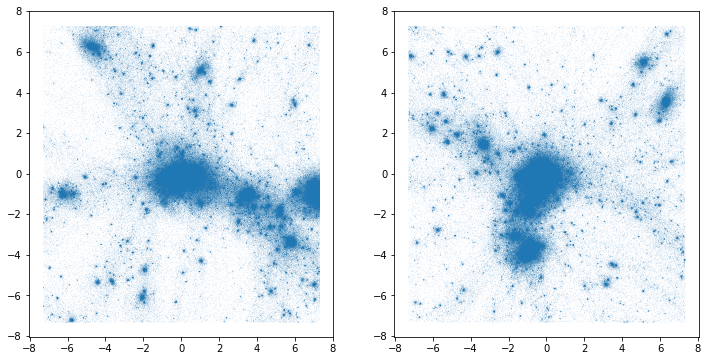

In [65]:
random = np.random.randint(0,len(ppx),1000000,dtype='int64')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(ppx[random],ppy[random],'.',ms=0.025)
ax[1].plot(ppy[random],ppz[random],'.',ms=0.025)

Recenter the sub-halos as well. Switch to physical coordinates by using the scale size and taking out h0

In [66]:
gal_ppx = subhalos['px']/h0*a_halo # convert to physical coords
gal_ppy = subhalos['py']/h0*a_halo
gal_ppz = subhalos['pz']/h0*a_halo
gal_ppx = gal_ppx - Halo_p[0]
gal_ppy = gal_ppy - Halo_p[1]
gal_ppz = gal_ppz - Halo_p[2]

Plot the sub-halos on top of the particles. Things should line up.

In [67]:
random = np.random.randint(0,len(ppx),1000000,dtype='int64')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(ppx[random],ppy[random],'.',ms=0.025)
ax[0].plot(gal_ppx, gal_ppy, 'ro',ms=0.25)
ax[1].plot(ppy[random],ppz[random],'.',ms=0.025)
ax[1].plot(gal_ppy, gal_ppz, 'o',ms=0.25,color='red')

Now let's calculate the DM density profile and compare to the fit.

In [68]:
rpart = np.sqrt(ppx**2.0 + ppy**2.0 + ppz**2.0)
dens_radius_bookends = np.linspace(0.0,5.0,100)
density = []
cumul_density = []
dens_radius = []
for i in range(99):
    dens_radius = np.append(dens_radius, (dens_radius_bookends[i+1] + dens_radius_bookends[i])/2.0)
    volume = 4./3.*np.pi*(dens_radius_bookends[i+1]**3.0 - dens_radius_bookends[i]**3.0 )
    count = len(np.where((rpart > dens_radius_bookends[i]) & (rpart < dens_radius_bookends[i+1]))[0])
    density = np.append(density,count*resolution/volume)
    count = len(np.where((rpart < dens_radius_bookends[i+1]))[0])
    volume = 4./3.*np.pi*(dens_radius_bookends[i+1]**3.0)
    cumul_density = np.append(cumul_density, count*resolution/volume)

Note that we calculate drho/dr (the differential density or density/delta volume) and the cumulative density profile.

The latter is necessary to compare to the M200 published by the TNG team.

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(dens_radius, rho_einasto(dens_radius,density_prof['rho_0'][clus_num],density_prof['h'][clus_num],density_prof['n'][clus_num]),'+',color='r',ms=10,label='Einasto')
ax[0].plot(dens_radius, density)
ax[1].plot(dens_radius, cumul_density,label='Particles')
ax[1].plot(density_cumul['radius'], density_cumul['rho_tot'],label='All matter')
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
ax[1].axhline(200*rho_crit.value)
ax[0].set_yscale('log')
ax[0].set_title('Particle Density')
ax[0].set_xlim(0,2*cluster_list['r200crit'][clus_num]/1000.0/h0)
ax[0].legend()
ax[1].set_yscale('log')
ax[1].set_title('Cumulative Density')
r200 = dens_radius[np.where(cumul_density < 200*rho_crit.value)[0][0]]
ax[1].axvline(cluster_list['r200crit'][clus_num]/1000.0/h0)
ax[1].axvline(r200, color='k',label = 'Fit r200')
ax[1].set_xlim(0,2*r200)
ax[1].legend()
ax[0].axvline(r200)
plt.show()
w = np.where(rpart < r200)[0]
mass200 = len(w)*resolution
print 'Our inferred DM log10(M200_crit) = ', np.log10(mass200)
print 'TNG reported log10(m200crit) = ', np.log10(cluster_list['m200crit'][clus_num]*1e10/h0)
r200 = cluster_list['r200crit'][clus_num]/1000.0/h0

Our inferred DM log10(M200_crit) =  14.264181411927515
TNG reported log10(m200crit) =  14.358233915619659


In the above plot (right), the total matter cumulative density should intersect 200x rho_crit (horizontal line) at R200. The particle cluster "mass" should be lower with a smaller R200. The Einasto fit will likely undershoot the particles in the outskirts where the local background density begins to enter the equation.

What about M200 from the Einasto fit? From the above plot (left), it looks like Einasto will underestimate the M200.

In [70]:
len_r = len(dens_radius)
len_r_interp = 9999
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
r_denfit = np.linspace(np.min(dens_radius),np.max(dens_radius),len_r).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
r_interp = np.linspace(np.min(dens_radius)+0.001,np.max(dens_radius)-0.001,len_r_interp).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.    
M200_fitted = []
R200_fitted = []
rho_r = []
for j in range(len_r):
            rho_r = np.append(rho_r,4*np.pi*integrate.quad(rho_einasto_int,0,r_denfit[j],args=(density_prof['rho_0'][clus_num],density_prof['h'][clus_num],density_prof['n'][clus_num]))[0]/(4/3.*np.pi*(r_denfit[j]**3.0)))
log10_rho_r_func = interp1d(dens_radius, np.log10(rho_r), kind='quadratic')
log10_rho_r_interp = log10_rho_r_func(r_interp)
w = np.where(log10_rho_r_interp < np.log10(200*rho_crit.value))[0]
if (len(w) >0):
        R200_fitted = np.append(R200_fitted,r_interp[w[0]])
        M200_fitted = np.append(M200_fitted, 4*np.pi*integrate.quad(rho_einasto_int,0,r_interp[w[0]],args=(density_prof['rho_0'][clus_num],density_prof['h'][clus_num],density_prof['n'][clus_num]))[0])
print 'The Einasto inferred DM log10(M200) = ', np.log10(M200_fitted[0])
print 'The TNG log10(m200crit) = ', np.log10(cluster_list['m200crit'][clus_num]*1e10/h0)

The Einasto inferred DM log10(M200) =  14.177739431024166
The TNG log10(m200crit) =  14.358233915619659


## Phase-space mass estimation.

Next, let us look at the phase-space data of the sub-halos and/or galaxies.

First, let's look at this in "3D" by calculating the radial (or tangential) velocities of any particle. 

In [71]:
vvx = particles['vx']
vvy = particles['vy']
vvz = particles['vz']
gal_rpart = np.sqrt(gal_ppx**2.0 + gal_ppy**2.0 + gal_ppz**2.0)
gal_vvx = subhalos['vx'] #Convert from Halo Finder units to physical units (only for particles)
gal_vvy = subhalos['vy']
gal_vvz = subhalos['vz']
wr200 = np.where(rpart < r200)[0]
gal_vvx = gal_vvx - np.mean(vvx[wr200])
gal_vvy = gal_vvy - np.mean(vvy[wr200])
gal_vvz = gal_vvz - np.mean(vvz[wr200])
Ngal = len(np.where((gal_rpart > 0.3*r200) & (gal_rpart < r200))[0])
print '3D Phase-space richness = ', Ngal

gal_vpart = np.sqrt(gal_vvx**2.0 + gal_vvy**2.0 + gal_vvz**2.0)
thetavec = np.arccos(gal_ppz/np.sqrt(gal_ppx**2.0 + gal_ppy**2.0 + gal_ppz**2.0))
phivec = np.arctan2(gal_ppy,gal_ppx)
gal_vtheta = gal_vvx*np.cos(thetavec)*np.cos(phivec) + gal_vvy*np.cos(thetavec)*np.sin(phivec) - gal_vvz*np.sin(thetavec)
gal_vphi = -gal_vvx*np.sin(phivec) + gal_vvy*np.cos(phivec)
gal_vrad = gal_vvx*gal_ppx/ gal_rpart + gal_vvy*gal_ppy/gal_rpart + gal_vvz*gal_ppz/gal_rpart # calculate the radial component of the velocities
vflow = cosmo.H(z).value*gal_rpart
gal_vr_tot = gal_vrad + vflow # Add in the Hubble flow
gal_vtan = np.sqrt(gal_vtheta**2.0 + gal_vphi**2.0)

3D Phase-space richness =  513


Now, make a theory prediction for this cluster given the statistical under-sampling of the phase-space (Ngal). Use the Dark Skies m200crit.

In [72]:
radial_bins = 10
M200_orig = np.log10(cluster_list['m200crit'][clus_num]*1e10/h0)
M200_use = np.repeat(10**M200_orig,(1))
z = np.array((0.01))
z = np.repeat(z,(1))
N = np.repeat(Ngal,len(z))
#N = np.repeat(1e8,len(z))
num_clus = 1
rho_0 = np.repeat(density_prof['rho_0'][clus_num],(1))
h = np.repeat(density_prof['h'][clus_num],(1))
n = np.repeat(density_prof['n'][clus_num],(1))
radius_array = np.linspace(0.1,3.5,radial_bins).round(3) #specify radius array for profiles in Mpc
theta_data = np.zeros((1,radial_bins))
theta_data[0,:] = radius_array /D_A(z[0], cosmo_params, cosmo.name) #calculate the angular radial coordinates in some cosmology
r_NFW,vesc_NFW = v_esc_NFW_M200(theta_data,z,M200_use,N,cosmo_params, cosmo_name, num_clus)
print r_NFW, vesc_NFW

[[0.1   0.478 0.856 1.233 1.611 1.989 2.367 2.744 3.122 3.5  ]] [[1953.93866215 1564.40946111 1334.18012596 1171.0241288  1043.72290321
   939.05324684  849.68013934  771.42203907  701.04010421  636.80655337]]


Now plot the phase-space (of radial velocities) and put on the theory.

In [73]:
plt.plot(gal_rpart, gal_vr_tot, '.', label = 'Galaxies')
plt.plot(r_NFW[0],vesc_NFW[0], 'r',label = 'From NFW M200')
plt.plot(r_NFW[0],-vesc_NFW[0], 'r')
plt.xlim(0,1.5*r200)
plt.ylim(-5000,5000)
plt.axvline(0.3*r200)
plt.axvline(r200)
plt.legend()
plt.show()

The range between the lines is 0.3r200 to r200. We will use the "3D" (or radial) escape profile (which is suppressed) to measure an edge and try and infer back the mass. Obviously, we should do pretty well.

This has more or less been investigated in [Miller et al. 2016](https://iopscience.iop.org/article/10.3847/0004-637X/822/1/41) . While they did not use the 3D information to infer the masses, they did show that the escape theory can predict the escape edge to high precision and accuracy for the Millennium. The reverse would have to be true.

Define the code and functions required to make the line-of-sight projections

In [74]:
def Pick_pos(halop):
    x = np.random.uniform(-1,1)
    y = np.random.uniform(-1,1)
    z = np.random.uniform(-1,1)
    unit = np.array([x,y,z])/(x**2+y**2+z**2)**(.5)
    return unit

In [75]:
def perpendicular_vector(v):
    r""" Finds an arbitrary perpendicular vector to *v*."""
    # for two vectors (x, y, z) and (a, b, c) to be perpendicular,
    # the following equation has to be fulfilled
    #     0 = ax + by + cz

    # x = y = z = 0 is not an acceptable solution
    if v[0] == v[1] == v[2] == 0:
        raise ValueError('zero-vector')

    # If one dimension is zero, this can be solved by setting that to
    # non-zero and the others to zero. Example: (4, 2, 0) lies in the
    # x-y-Plane, so (0, 0, 1) is orthogonal to the plane.
    if v[0] == 0:
        return [1, 0, 0]
    if v[1] == 0:
        return [0, 1, 0]
    if v[2] == 0:
        return [0, 0, 1]

    # arbitrarily set a = b = 1
    # then the equation simplifies to
    #     c = -(x + y)/z
    return [1, 1, -1.0 * (v[0] + v[1]) / v[2]]

This function is written in the language C. We will use the libary weave to make this call externally via the WEAVE library. You will need to make sure this is installed and working for you. The use of C helps speed things up.

In [76]:
code = """
       int u,w;
       for (u=0;u<n;++u){
       for(w=0;w<3;++w){
           gal_pos_vect(w,u) = (gal_p(w,u)-new_pos(w))/gal_dist(u);
           }
       gal_vlos(u) = gal_pos_vect(0,u)*gal_v(0,u)+gal_pos_vect(1,u)*gal_v(1,u)+gal_pos_vect(2,u)*gal_v(2,u);
       }
       """

In [82]:
gal_v = np.array([gal_vvx,gal_vvy,gal_vvz])
gal_p = np.array([gal_ppx,gal_ppy,gal_ppz])
rotdo = 30
r1_vec = np.zeros((len(r1),rotdo))
v1_vec = np.zeros((len(v1),rotdo))

for i in range(rotdo):
    prefactor = np.random.randint(0,180)
    new_pos = np.array((60*np.cos(prefactor*np.pi/180.0),60*np.sin(prefactor*np.pi/180.0),0))
    halo_dist = ((new_pos[0])**2 + (new_pos[1])**2 + (new_pos[2])**2)**0.5
    halo_pos_vect = np.array([-new_pos[0],-new_pos[1],-new_pos[2]])/halo_dist
    halo_vlos = np.dot(halo_pos_vect, Halo_v[:])
    gal_dist = ((gal_p[0]-new_pos[0])**2 + (gal_p[1]-new_pos[1])**2 + (gal_p[2]-new_pos[2])**2)**0.5
    gal_vlos = np.zeros(gal_dist.size)
    n = gal_dist.size
    gal_pos_vect = np.zeros((3,gal_dist.size))
    fast = weave.inline(code,['gal_pos_vect','n','gal_dist','gal_vlos','gal_v','new_pos','gal_p'],type_converters=converters.blitz,compiler='gcc')
    r1 = (halo_dist**2-np.dot(halo_pos_vect*halo_dist,gal_pos_vect)**2)**0.5
    v1 = gal_vlos-halo_vlos*np.dot(halo_pos_vect,gal_pos_vect) 
    r1_vec[:,i] = r1
    v1_vec[:,i] = v1

if PLOTIT:
    normal_vect = np.array([-new_pos[0],-new_pos[1],-new_pos[2]])/halo_dist
    perp_vector = perpendicular_vector(normal_vect)
    perp_vector = (perp_vector[0],perp_vector[1],perp_vector[2]) /np.sqrt(perp_vector[0]**2.0 + perp_vector[1]**2.0 + perp_vector[2]**2.0)
    galx_rel = np.subtract(gal_ppx,new_pos[0])
    galy_rel = np.subtract(gal_ppy,new_pos[1])
    galz_rel = np.subtract(gal_ppz,new_pos[2])
    gal_projx = np.zeros(len(galx_rel))
    gal_projy = np.zeros(len(galy_rel))

In [83]:
print np.shape(r1_vec)

(5040, 30)


In [84]:
#Take last one and plot it (if true)
if PLOTIT:
    normal_vect = np.array([-new_pos[0],-new_pos[1],-new_pos[2]])/halo_dist
    perp_vector = perpendicular_vector(normal_vect)
    perp_vector = (perp_vector[0],perp_vector[1],perp_vector[2]) /np.sqrt(perp_vector[0]**2.0 + perp_vector[1]**2.0 + perp_vector[2]**2.0)
    galx_rel = np.subtract(gal_ppx,new_pos[0])
    galy_rel = np.subtract(gal_ppy,new_pos[1])
    galz_rel = np.subtract(gal_ppz,new_pos[2])
    gal_projx = np.zeros(len(galx_rel))
    gal_projy = np.zeros(len(galy_rel))
    
    for kk in range(len(galx_rel)):
        gal_projx[kk] = np.dot([galx_rel[kk],galy_rel[kk],galz_rel[kk]], perp_vector)
        gal_projy[kk] = np.dot([galx_rel[kk],galy_rel[kk],galz_rel[kk]], np.cross(normal_vect,perp_vector))
    rdist = []
    for kk in range(len(galx_rel)):
        rdist = np.append(rdist,np.sqrt((gal_projx[kk])**2.0 + (gal_projy[kk])**2.0) ) 
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    ax[0].plot(r1,v1,'.',ms =4)
    ax[0].plot(r_NFW[0], vesc_NFW[0],'r-')
    ax[0].plot(r_NFW[0], -vesc_NFW[0],'r-')
    ax[0].axvline(r200,color='k',linewidth=2)
    ax[0].set_xlim(0,1.5*r200)
    #    plt.plot(r_NFW[0],-vesc_NFW[0],'r-')
    ax[1].plot(gal_projx,gal_projy,'.',ms=2)
    plt.show()

make the "surfaces" to constrain against

In [96]:
rbins = 10
binsize = (1.0-0.3)*r200/rbins

r_fit = np.zeros((rbins,rotdo))
v_fit_max = np.zeros((rbins,rotdo))
v_fit_minmax = np.zeros((rbins,rotdo))
v_fit_minmaxavg = np.zeros((rbins,rotdo))
v_fit_max_cored = np.zeros((rbins,rotdo))
v_fit_range = np.zeros((rbins,rotdo))
radius_min = 0.3*r200
for j in range(rotdo):
    r_min = radius_min
    for i in range(10):
        r_max = binsize + r_min
        r_fit[i,j] = (r_min + r_max)/2.0
        w = np.where((r1_vec[:,j]>r_min) & (r1_vec[:,j]<r_max))[0]
        v_fit_minmaxavg[i,j] = (np.max(v1_vec[w,j]) -np.min(v1_vec[w,j]))/2.0
        v_fit_max[i,j] = np.max((np.max(v1_vec[w,j]), -np.min(v1_vec[w,j])))
        v_fit_minmax[i,j] = np.min((np.max(v1_vec[w,j]), -np.min(v1_vec[w,j])))
        if (i<2):
            v_fit_max_cored[i,j] = np.max(v1_vec[w,j]) -np.min(v1_vec[w,j])/2.0
        elif (i>=2):
            v_fit_max_cored[i,j] = np.max((np.max(v1_vec[w,j]), -np.min(v1_vec[w,j])))
        v_fit_range[i,j] = np.max([500.0,(np.max(v1_vec[w,j]) +np.min(v1_vec[w,j]))])
        r_min = r_min + binsize
#    v_fit = np.append(v_fit, np.max(np.abs(galaxy_v[w])))
PLOTIT = True
j = 29                                     
if PLOTIT:
    plt.plot(r1_vec[:,j],v1_vec[:,j],'.',ms=4)
    plt.plot(r_fit[:,j], v_fit_max[:,j],'ro-', label = 'Max')
    plt.plot(r_fit[:,j], -v_fit_max[:,j],'ro-')
    plt.plot(r_fit[:,j], v_fit_minmax[:,j],'yo-', label = "Minmax")
    plt.plot(r_fit[:,j], -v_fit_minmax[:,j],'yo-')
    plt.plot(r_fit[:,j], v_fit_minmaxavg[:,j],'co-', label = 'Minmax average')
    plt.plot(r_fit[:,j], -v_fit_minmaxavg[:,j],'co-')
    plt.plot(r_fit[:,j], v_fit_max_cored[:,j],'o-',c='orange', label = 'Max cored')
    plt.plot(r_fit[:,j], -v_fit_max_cored[:,j],'o-',c='orange')
    plt.errorbar(r_fit[:,j],v_fit_max[:,j],yerr=v_fit_range[:,j],color='k', linestyle='None')
    plt.errorbar(r_fit[:,j],-v_fit_max[:,j],yerr=v_fit_range[:,j],color='k', linestyle='None')
    plt.ylim(-5000,5000)
    plt.xlim(0,1.5*r200)
    plt.legend()
    plt.axvline(r200,linewidth=2,color='k')
    plt.axvline(0.3*r200,linewidth=2,color='k')
    plt.show()
    w = np.where((r1 > 0.3*r200) & (r1 < r200))[0]
    print "2D Phase-space richness: ", len(w)

#for i in range(rotdo):
#    filename = 
#    t = Table([r_vescmax[:,i], vt_vescmax[:,i],vp_vescmax[:,i],v2_vescmax[:,i], v3d_vescmax[:,i]],  names=('radius_mpc','v2_theta',
#                                                                                           'v2_phi','v2_rad', 'v2_3d'))
#    t.write(filename, format='fits',overwrite=True)

2D Phase-space richness:  997


In [102]:
one = 0
two = 9
R200_guess = 2.5
z = np.repeat(0.001, rotdo)
N = np.repeat(0,len(z))
p_z = np.repeat(z,len(z))
p_num_clus = num_clus
p_cosmo_params = cosmo_params
p_cosmo_name = cosmo_name
vesc_data_theta = np.zeros((rotdo,two-one))
vesc_data_r = np.zeros((rotdo,two-one))
vesc_data = np.zeros((rotdo,two-one))
vesc_data_err = np.zeros((rotdo,two-one))
print np.shape(vesc_data_theta), len(z)
for i in range(rotdo):
    N[i] = len(np.where((r1_vec[:,j] >0.3*R200_guess) & (r1_vec[:,j] <1.0*R200_guess))[0])
    vesc_data_theta[i,:] = (1000.0*r_fit[one:two,i])/(cosmo.kpc_proper_per_arcmin(z[i]))/60.0*np.pi/180.0
    vesc_data_r[i,:] = r_fit[one:two,i]
    vesc_data[i,:] = v_fit_max[one:two,i]
    vesc_data_err = v_fit_range[one:two,i]

(30, 9) 30


In [112]:
num_clus = rotdo

In [113]:
def lnprior(omega):
    p_log10M200 = omega[0]
    if not(13 < p_log10M200 < 17 ):
          return -np.inf
    return 0.0

In [114]:
def lnlike(omega, x, y, yerr): 
    p_theta_array = x
    p_z = z
    p_M200 = np.repeat(10**omega[0],len(p_z))
    p_N = np.repeat(num_mem,len(p_z))
    p_num_clus = num_clus
    p_cosmo_params = cosmo_params
    p_cosmo_name = cosmo_name
    ymodel_fixed = lambda p_theta_array,p_M200:v_esc_NFW_M200(p_theta_array,p_z,p_M200,p_N,p_cosmo_params,p_cosmo_name,p_num_clus)
    rand = np.random.randint(0,1000)
    Zv1 = Zv_uniform(N,rand)
    Zv2 = Zv_uniform(2*N,rand)
    r_cosmo, ymodel = ymodel_fixed(p_theta_array,p_M200)
    Zv_vec = np.zeros((len(vesc_data_r[0])))
    Zv_vec= np.append(np.repeat(Zv2,2),np.repeat(Zv1,len(Zv_vec)-2))
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
    ymodel[0] = ymodel[0]/Zv_vec
    inv_sigma2 = 1.0/(yerr**2)
#    print -0.5*(np.sum((y-ymodel)**2*inv_sigma2))
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

In [115]:
def lnprob(omega, x, y, yerr):
    lp = lnprior(omega)
    ll = lnlike(omega, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    return lp + lnlike(omega, x, y, yerr)

In [116]:
ndim, nwalkers, nsteps = 1, 200, 1000
p0 = np.transpose([np.random.uniform(13,17,size=nwalkers)])
print np.shape(p0)

(200, 1)


In [117]:
pool_count =  multiprocessing.cpu_count()
pool = Pool(processes=pool_count)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(vesc_data_theta, vesc_data, vesc_data_err),pool=pool)
sampler.run_mcmc(p0, nsteps)

emcee: Exception while calling your likelihood function:
('  params:', array([14.69498634]))
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258,

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)


emcee: Exception while calling your likelihood function:
('  params:', array([13.8131745]))
emcee: Exception while calling your likelihood function:
('  params:', array([16.46939999]))
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
('  params:', array([15.42764954]))
('  params:', array([13.52857241]))
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.1

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

Traceback (most recent call last):
    return self.f(x, *self.args, **self.kwargs)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob


ValueError: cannot reshape array of size 270 into shape (1,9)

    return self.f(x, *self.args, **self.kwargs)


('  kwargs:', {})


  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))



('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 ,

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)


Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc


('  kwargs:', {})
  exception:


    ll = lnlike(omega, x, y, yerr)


('  kwargs:', {})


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return getattr(obj, method)(*args, **kwds)


  exception:


    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
Traceback (most recent call last):
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
ValueError: cannot reshape array of size 270 into shape (1,9)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
Traceback (most recent call last):


emcee: Exception while calling your likelihood function:


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape


emcee: Exception while calling your likelihood function:


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


('  kwargs:', {})
emcee: Exception while calling your likelihood function:


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return _wrapfunc(a, 'reshape', newshape, order=order)


  exception:
('  params:', array([16.20162815]))


Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return self.f(x, *self.args, **self.kwargs)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    ll = lnlike(omega, x, y, yerr)
    return self.f(x, *self.args, **self.kwargs)


('  params:', array([14.36437569]))
emcee: Exception while calling your likelihood function:


  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    return self.f(x, *self.args, **self.kwargs)


('  params:', array([16.84777755]))


  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    ll = lnlike(omega, x, y, yerr)


('  params:', array([14.49143463]))


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)



emcee: Exception while calling your likelihood function:


    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc


('  kwargs:', {})
emcee: Exception while calling your likelihood function:
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.138

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc


  exception:


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return _wrapfunc(a, 'reshape', newshape, order=order)
    return getattr(obj, method)(*args, **kwds)
    return getattr(obj, method)(*args, **kwds)



('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 ,

ValueError: cannot reshape array of size 270 into shape (1,9)


('  params:', array([15.22730192]))


Traceback (most recent call last):


('  params:', array([14.64540906]))


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)
Traceback (most recent call last):



('  kwargs:', {})
('  params:', array([14.91968827]))


    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


  exception:


  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
ValueError: cannot reshape array of size 270 into shape (1,9)


('  kwargs:', {})


Traceback (most recent call last):


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


    return self.f(x, *self.args, **self.kwargs)
    return self.f(x, *self.args, **self.kwargs)


  exception:


  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob


('  kwargs:', {})


    ll = lnlike(omega, x, y, yerr)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return getattr(obj, method)(*args, **kwds)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
ValueError: cannot reshape array of size 270 into shape (1,9)


    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
    ll = lnlike(omega, x, y, yerr)


('  kwargs:', {})



  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    return _wrapfunc(a, 'reshape', newshape, order=order)
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))


  exception:
('  kwargs:', {})


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc


  exception:


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
Traceback (most recent call last):
    return getattr(obj, method)(*args, **kwds)
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return _wrapfunc(a, 'reshape', newshape, order=order)
ValueError: cannot reshape array of size 270 into shape (1,9)


    return self.f(x, *self.args, **self.kwargs)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


('  kwargs:', {})


    return getattr(obj, method)(*args, **kwds)
    return self.f(x, *self.args, **self.kwargs)


  exception:


ValueError: cannot reshape array of size 270 into shape (1,9)
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)
    ll = lnlike(omega, x, y, yerr)
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
ValueError: cannot reshape array of size 270 into shape (1,9)
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, or

emcee: Exception while calling your likelihood function:


    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
    ll = lnlike(omega, x, y, yerr)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape


  exception:
('  params:', array([14.45783189]))


    return _wrapfunc(a, 'reshape', newshape, order=order)
    return getattr(obj, method)(*args, **kwds)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
ValueError: cannot reshape array of size 270 into shape (1,9)


emcee: Exception while calling your likelihood function:


    return _wrapfunc(a, 'reshape', newshape, order=order)
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
    return getattr(obj, method)(*args, **kwds)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
ValueError: cannot reshape array of size 270 into shape (1,9)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
    return self.f(x, *self.args, **self.kwargs)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

    return getattr(obj, method)(*args, **kwds)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
ValueError: cannot reshape array of size 270 into shape (1,9)
    ll = lnlike(omega, x, y, yerr)


    return getattr(obj, method)(*args, **kwds)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
ValueError: cannot reshape array of size 270 into shape (1,9)
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.

emcee: Exception while calling your likelihood function:


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape


('  params:', array([14.03800163]))
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        

    return _wrapfunc(a, 'reshape', newshape, order=order)



('  kwargs:', {})
  exception:


Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)


emcee: Exception while calling your likelihood function:


ValueError: cannot reshape array of size 270 into shape (1,9)


emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
('  params:', array([13.47284213]))
('  params:', array([13.44212647]))
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886

Traceback (most recent call last):


emcee: Exception while calling your likelihood function:
('  params:', array([15.27198202]))


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
Traceback (most recent call last):


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

    ll = lnlike(omega, x, y, yerr)



('  params:', array([16.20918654]))


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
    return self.f(x, *self.args, **self.kwargs)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob


emcee: Exception while calling your likelihood function:
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763,

    return _wrapfunc(a, 'reshape', newshape, order=order)
    ll = lnlike(omega, x, y, yerr)


emcee: Exception while calling your likelihood function:

  exception:
emcee: Exception while calling your likelihood function:

('  params:', array([14.12461156]))


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
Traceback (most recent call last):
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    return getattr(obj, method)(*args, **kwds)
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


('  kwargs:', {})


ValueError: cannot reshape array of size 270 into shape (1,9)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return self.f(x, *self.args, **self.kwargs)
    return _wrapfunc(a, 'reshape', newshape, order=order)


  exception:
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269,

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc


('  params:', array([14.95388931]))


    return getattr(obj, method)(*args, **kwds)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob


('  params:', array([13.57368191]))


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
ValueError: cannot reshape array of size 270 into shape (1,9)
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))



('  params:', array([15.84671198]))
('  kwargs:', {})


  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike


('  kwargs:', {})
  exception:


Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape


('  kwargs:', {})


    return _wrapfunc(a, 'reshape', newshape, order=order)


emcee: Exception while calling your likelihood function:


Traceback (most recent call last):
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


('  params:', array([16.43736357]))
  exception:


    return getattr(obj, method)(*args, **kwds)


emcee: Exception while calling your likelihood function:


    return self.f(x, *self.args, **self.kwargs)
    return _wrapfunc(a, 'reshape', newshape, order=order)
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
ValueError: cannot reshape array of size 270 into shape (1,9)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


('  params:', array([16.18436311]))


    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)


  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return getattr(obj, method)(*args, **kwds)
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
    return self.f(x, *self.args, **self.kwargs)
ValueError: cannot reshape array of size 270 into shape (1,9)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    return _wrapfunc(a, 'reshape', newshape, order=order)
    ll = lnlike(omega, x, y, yerr)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc


  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    return getattr(obj, method)(*args, **kwds)
    ll = lnlike(omega, x, y, yerr)


('  kwargs:', {})


    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
ValueError: cannot reshape array of size 270 into shape (1,9)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape


  exception:


  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike


    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


  exception:


    return self.f(x, *self.args, **self.kwargs)


('  kwargs:', {})


    return _wrapfunc(a, 'reshape', newshape, order=order)
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob


  exception:


    return getattr(obj, method)(*args, **kwds)
    return self.f(x, *self.args, **self.kwargs)
    ll = lnlike(omega, x, y, yerr)
ValueError: cannot reshape array of size 270 into shape (1,9)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    ll = lnlike(omega, x, y, yerr)
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike


('  kwargs:', {})


Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))


  exception:


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


  exception:


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
    return _wrapfunc(a, 'reshape', newshape, order=order)
    return _wrapfunc(a, 'reshape', newshape, order=order)
Traceback (most recent call last):
    return self.f(x, *self.args, **self.kwargs)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    return getattr(obj, method)(*args, **kwds)
    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)
Valu

emcee: Exception while calling your likelihood function:


    ll = lnlike(omega, x, y, yerr)


('  params:', array([13.40548721]))


  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))


emcee: Exception while calling your likelihood function:


    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))


('  params:', array([13.71804534]))


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc


  exception:



Traceback (most recent call last):


('  kwargs:', {})


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


  exception:


Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return _wrapfunc(a, 'reshape', newshape, order=order)
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc


emcee: Exception while calling your likelihood function:


    return getattr(obj, method)(*args, **kwds)


('  params:', array([16.89880496]))


ValueError: cannot reshape array of size 270 into shape (1,9)
ValueError: cannot reshape array of size 270 into shape (1,9)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

Traceback (most recent call last):


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__



('  kwargs:', {})
  exception:


Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)


emcee: Exception while calling your likelihood function:


    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob


emcee: Exception while calling your likelihood function:
('  params:', array([15.26731906]))


  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob


('  params:', array([15.426563]))
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.

    ll = lnlike(omega, x, y, yerr)
    ll = lnlike(omega, x, y, yerr)


  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike


('  kwargs:', {})


  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))


  exception:
emcee: Exception while calling your likelihood function:


    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
Traceback (most recent call last):


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)


('  kwargs:', {})
emcee: Exception while calling your likelihood function:


    return self.f(x, *self.args, **self.kwargs)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc


('  params:', array([15.15320028]))


  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob


  exception:


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    ll = lnlike(omega, x, y, yerr)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

    return getattr(obj, method)(*args, **kwds)
    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
ValueError: cannot reshape array of size 270 into shape (1,9)


    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape


('  params:', array([16.4294506]))
emcee: Exception while calling your likelihood function:



Traceback (most recent call last):


('  kwargs:', {})


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


('  kwargs:', {})
  exception:
  exception:
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,


    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
Traceback (most recent call last):
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


    return self.f(x, *self.args, **self.kwargs)
    ll = lnlike(omega, x, y, yerr)


emcee: Exception while calling your likelihood function:


    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob


('  kwargs:', {})


  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike


('  params:', array([16.80105878]))
  exception:


  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
Traceback (most recent call last):
    ll = lnlike(omega, x, y, yerr)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    return _wrapfunc(a, 'reshape', newshape, order=order)
    return self.f(x, *self.args, **self.kwargs)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob


emcee: Exception while calling your likelihood function:


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    ll = lnlike(omega, x, y, yerr)
    return getattr(obj, method)(*args, **kwds)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

ValueError: cannot reshape array of size 270 into shape (1,9)
    return _wrapfunc(a, 'reshape', newshape, order=order)



('  params:', array([13.28483976]))


    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))


('  kwargs:', {})
('  params:', array([16.32432934]))


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return getattr(obj, method)(*args, **kwds)
    return _wrapfunc(a, 'reshape', newshape, order=order)
ValueError: cannot reshape array of size 270 into shape (1,9)
    return _wrapfunc(a, 'reshape', newshape, order=order)
    ll = lnlike(omega, x, y, yerr)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    return getattr(obj, method)(*args, **kwds)
    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)
    np.reshape(Zv_vec,(1,le

('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

ValueError: cannot reshape array of size 270 into shape (1,9)
    return _wrapfunc(a, 'reshape', newshape, order=order)


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc


('  kwargs:', {})
  exception:


    return getattr(obj, method)(*args, **kwds)


  exception:


Traceback (most recent call last):
ValueError: cannot reshape array of size 270 into shape (1,9)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
Traceback (most recent call last):
    return self.f(x, *self.args, **self.kwargs)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    return self.f(x, *self.args, **self.kwargs)
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob


('  params:', array([13.60249936]))


  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike


    ll = lnlike(omega, x, y, yerr)


('  kwargs:', {})


    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike


emcee: Exception while calling your likelihood function:


    return _wrapfunc(a, 'reshape', newshape, order=order)


  exception:


    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))


('  params:', array([14.06843293]))


Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

ValueError: cannot reshape array of size 270 into shape (1,9)


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc


('  kwargs:', {})


    return getattr(obj, method)(*args, **kwds)


  exception:


    return self.f(x, *self.args, **self.kwargs)
ValueError: cannot reshape array of size 270 into shape (1,9)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
Traceback (most recent call last):
    ll = lnlike(omega, x, y, yerr)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    return self.f(x, *self.args, **self.kwargs)
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

    ll = lnlike(omega, x, y, yerr)
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
    return getattr(obj, method)(*args, **kwds)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
ValueError: cannot reshape array of size 270 into shape (1,9)
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc



('  kwargs:', {})


    return getattr(obj, method)(*args, **kwds)


  exception:


ValueError: cannot reshape array of size 270 into shape (1,9)
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)


emcee: Exception while calling your likelihood function:
('  params:', array([13.07176751]))
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258,

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)


emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
('  params:', array([13.38803382]))
('  params:', array([16.89157435]))
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

    return self.f(x, *self.args, **self.kwargs)


  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob


('  kwargs:', {})


    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike


  exception:


    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return _wrapfunc(a, 'reshape', newshape, order=order)
    return self.f(x, *self.args, **self.kwargs)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    return getattr(obj, method)(*args, **kwds)
    ll = lnlike(omega, x, y, yerr)
ValueError: cannot reshape array of size 270 into shape (1,9)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _

emcee: Exception while calling your likelihood function:
('  params:', array([13.25542223]))
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258,

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)


emcee: Exception while calling your likelihood function:
('  params:', array([14.36574005]))
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258,

Traceback (most recent call last):


emcee: Exception while calling your likelihood function:


  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__


('  params:', array([16.92709374]))


    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)


('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)


emcee: Exception while calling your likelihood function:
('  params:', array([14.51361668]))
('  args:', (array([[0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258, 0.1180576 , 0.13846262, 0.15886763, 0.17927265,
        0.19967767, 0.22008269, 0.2404877 , 0.26089272],
       [0.09765258,

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-115-57219d4e7ca9>", line 3, in lnprob
    ll = lnlike(omega, x, y, yerr)
  File "<ipython-input-114-f2a1be9c8a15>", line 16, in lnlike
    np.reshape(Zv_vec,(1,len(vesc_data_r[0])))
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 257, in reshape
    return _wrapfunc(a, 'reshape', newshape, order=order)
  File "/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 52, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)
ValueError: cannot reshape array of size 270 into shape (1,9)


(200, 1000, 1)


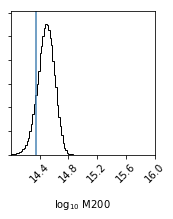

67
median(logM200) =  14.490431526353415 +/- 0.10871477976012045 0.11757297808618183
median(M200) =  309336755688105.4 +/- 87988623115644.12 73365801724986.28
True:  [14.35823392]


In [52]:
M200_use = [cluster_list['m200crit'][clus_num]/h0*1e10]
burn = 200
samples = sampler.chain[:, burn:, :].reshape((-1, 1))
print np.shape(sampler.chain)
fig = corner.corner(samples[:,:], bins=100, labels=["log$_{10}$ M200"], range=[(14.0,16.0)],truths = [np.log10(M200_use)])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print len(percentile_array)
M200_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
M200_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
M200_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
M200_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print 'median(logM200) = ', M200_fit_50, '+/-', M200_fit_67-M200_fit_50, M200_fit_50-M200_fit_33
print 'median(M200) = ', 10**(M200_fit_50), '+/-', 10**(M200_fit_67)-10**(M200_fit_50), 10**(M200_fit_50) -10**(M200_fit_33)
sigma_M200_fit = (M200_fit_67-M200_fit_50 + M200_fit_50-M200_fit_33)/2.0
print 'True: ', np.log10(M200_use)

M200_fitted_50 = np.repeat(M200_fit_50,len(z))
for i in range(len(z)):
    plt.plot(vesc_data_r[i],vesc_data[i],'o',color='grey', label = 'Edge')
    plt.errorbar(vesc_data_r[i],vesc_data[i],yerr=vesc_data_err[i],color='grey',  linestyle='None')
    plt.plot(vesc_data_r[i],-vesc_data[i],'o',color='grey')
    plt.errorbar(vesc_data_r[i],-vesc_data[i],yerr=vesc_data_err[i], linestyle='None',color='grey')
#for i in range(len(z)):
#    plt.plot(vesc_nfw_truth_r[i],vesc_nfw_truth[i],'-', label = 'Truth '+ str(i))
vesc_nfw_fit_r,vesc_nfw_fit = v_esc_NFW_M200(vesc_data_theta,z,10**M200_fitted_50,N,cosmo_params, cosmo_name,num_clus)
for i in range(len(z)):
    plt.plot(vesc_nfw_fit_r[i],vesc_nfw_fit[i],'b-', label = 'Dynamical Fit')
    plt.plot(vesc_nfw_fit_r[i],-vesc_nfw_fit[i],'b-')

vesc_nfw_true_r,vesc_nfw_true = v_esc_NFW_M200(vesc_data_theta,z,np.reshape(M200_use,(1,1)),N,cosmo_params, cosmo_name,num_clus)
for i in range(len(z)):
    plt.plot(vesc_nfw_true_r[i],vesc_nfw_true[i],'g-', label = 'True NFW')
    plt.plot(vesc_nfw_true_r[i],-vesc_nfw_true[i],'g-')

plt.plot(r1,v1,'k.')

plt.xlim(0,1.1*r200)
plt.ylim(-8000,5000)
plt.legend(loc=4)
plt.xlabel('r (Mpc)',size=18)
plt.ylabel(r'v (km/s)',size=18)
plt.show()

In [ ]:
for i in range(rotdo):
    filename = 
    t = Table([r_vescmax[:,i], vt_vescmax[:,i],vp_vescmax[:,i],v2_vescmax[:,i], v3d_vescmax[:,i]],  names=('radius_mpc','v2_theta',
                                                                                           'v2_phi','v2_rad', 'v2_3d'))
    t.write(filename, format='fits',overwrite=True)